In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from fastai.tabular.all import *
from multiprocessing import Pool
from sklearn.model_selection import KFold, GroupKFold
import lightgbm as lgb
from optiver_features import *
import pickle

In [3]:
df = pd.read_feather('train_351cols.feather')
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()


In [4]:
tars = torch.tensor(df.target.to_numpy())

In [3]:
df = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
time_ids = df.time_id.unique()
np.random.seed(42)
np.random.shuffle(time_ids)

splt = int(len(time_ids)*.7)
train_ids, test_ids = time_ids[:splt], time_ids[splt:]

len(train_ids), len(test_ids)

(2681, 1149)

In [4]:
len(df[df.time_id.isin(train_ids)]) / len(df)

0.6999944047075061

## Generate 5m dataset

In [5]:
book_feature_dict = {
    wap1: [],
    wap2: [],
    log_return1: [np.std],
    log_return2: [np.std],
  
    price_spread:[np.mean],
    total_volume:[np.mean],
}
trade_feature_dict = {
        log_return_price: [np.std],
        'seconds_in_bucket':[np.size],
        'size':[np.sum],
        'order_count':[np.sum],
}
time_id_features=[]
time_id_aggregations = []
stock_id_features = []
stock_id_aggregations = [time_id_aggregations]
time_windows = [(0,300), (0,100), (100,200), (200,300)]

In [6]:
def generate_0_to_5():


    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
    train_df5m = ofg.generate_train_df()
    ofg_targ =OptiverFeatureGenerator({wap1:[], log_return1:[realized_volatility]}, {'seconds_in_bucket':[np.size]}, [(300,600)], [],[],[],[])
    targ_df = ofg_targ.generate_train_df()
    train_df5m.target = targ_df.log_return1_realized_volatility_300_600
    train_df5m.target = train_df5m.target.replace(0, 1e-4)
    return train_df5m
    

In [7]:
%%time
train_df5m = generate_0_to_5()

CPU times: user 2.09 s, sys: 361 ms, total: 2.45 s
Wall time: 5min 14s


In [8]:

train_df5m.to_feather('train_5m.feather')

In [9]:
def rename_col(x):
    return x.replace('300', '600').replace('200', '500').replace('100', '400').replace('_0', '_300')
def rename_col_back(x):
    return x.replace('300', '0').replace('400', '100').replace('500', '200').replace('600', '300')

def generate_5_to_10():
    tw = [(x+300, y+300) for x,y in time_windows]
    time_id_feat = [rename_col(x) for x in time_id_features]
    stock_id_feat = [rename_col(x) for x in stock_id_features]
    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, tw, time_id_feat,time_id_aggregations, stock_id_feat, stock_id_aggregations)

    df = ofg.generate_train_df()
    df.columns = [rename_col_back(x) for x in df.columns]
    return df

In [10]:
train_df5_10m  = generate_5_to_10()

In [11]:
train_df5_10m.to_feather('train_5_10.feather')

In [11]:
cols_to_keep = ['log_return2_std_0_300',
 
 'stock_id','row_id', 'time_id', 'target',
 'log_return_price_std_0_300',
  'order_count_sum_0_300',
 'seconds_in_bucket_size_0_300',
 'size_sum_0_300',
 'log_return1_std_0_300',
 'log_return1_std_100_200',
 'log_return1_std_200_300',
 'price_spread_mean_0_300',

 'total_volume_mean_0_300']

In [12]:
train_df5m = train_df5m[cols_to_keep]
train_df5_10m = train_df5_10m[cols_to_keep]

## Learning embeddings

In [13]:
cont_nn,cat_nn = cont_cat_split(train_df5m, max_card=9000, dep_var='target')
cat_nn = ['time_id', 'stock_id']


procs_nn = [Categorify, FillMissing,Normalize]

splits = RandomSplitter(valid_pct=0.1,seed=43)(train_df5m)

dls = TabularPandas(train_df5m, procs_nn, cat_nn, cont_nn,
                      splits=splits, 
                       
                      y_names='target').dataloaders(1024)

def rmse(preds, targs):
    x = (targs-preds)
    return (x**2).mean().sqrt()

def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

config={'lin_first':True, 'ps':[0,0,0], 'embed_p':0.25, }
learn = tabular_learner(dls, y_range=(0,.1), layers=[200,100,40], emb_szs={'stock_id':5, 'time_id':10}, 
                        n_out=1, 
                        loss_func = rmspe, 
                        
                        metrics=AccumMetric(rmspe), config=config)

In [14]:
learn.fit_one_cycle(30, 5e-3)

epoch,train_loss,valid_loss,rmspe,time
0,7.050785,5.559433,5.565722,00:08
1,1.208669,0.773799,0.777571,00:02
2,0.561660,0.358072,0.360505,00:02
3,0.273972,0.266845,0.268151,00:02
4,0.275302,0.247844,0.248369,00:02
5,0.248121,0.243643,0.243996,00:02
6,0.256168,0.238732,0.239084,00:02
7,0.240676,0.238130,0.238685,00:02
8,0.258700,0.240750,0.241114,00:02
9,0.237155,0.229581,0.230120,00:02


In [15]:
categorify = dls.procs[2]
time_embs = learn.model.embeds[0].weight.data.cpu()
stock_embs = learn.model.embeds[1].weight.data.cpu()

In [16]:
def append_embs(data_df, categorify, time_embs, stock_embs):
    time_id_embs = dict()
    for idx, time_id in enumerate(categorify.classes['time_id']):
        time_id_embs[time_id] = time_embs[idx].tolist()

    stock_id_embs = dict()
    for idx, stock_id in enumerate(categorify.classes['stock_id']):
        stock_id_embs[stock_id] = stock_embs[idx].tolist()

    all_embs = []
    for _, row in (data_df[['stock_id', 'time_id']].iterrows()):
        emb1 = stock_id_embs[row.stock_id]
        emb2 = time_id_embs[row.time_id]
        all_embs.append(emb1+emb2)
    columns = [f'stock_emb{i}' for i in range(stock_embs.shape[1])] +[f'time_emb{i}' for i in range(time_embs.shape[1])]
    embs_df = pd.DataFrame(all_embs, columns=columns)

    return pd.concat([data_df, embs_df], axis=1)

In [17]:
test_df = train_df5_10m
test_dl = dls.test_dl(test_df)
preds, _ = learn.get_preds(dl=test_dl)
preds5_10 = preds.view(-1).numpy()

## LGBM 10m with trained embeddings

In [25]:
def rmspe_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe_np(y_true, y_pred), False
def train_LGB(train):
    # Hyperparammeters (optimized)
    seed = 29
    params = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
       # 'device':'gpu'
    }   
    
    # Split features and target
    x = train.drop(['row_id', 'target', 'time_id'], axis = 1)
    y = train['target']
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    models =[]
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create a KFold object
    kfold = GroupKFold()
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x, groups = train.time_id)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 3000, 
                          early_stopping_rounds = 25, 
                          verbose_eval = 100,
                          feval = feval_rmspe)
        models.append(model)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        #test_predictions += model.predict(x_test) / 10
        
    rmspe_score = rmspe_np(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return models

In [18]:
df = pd.read_feather('train_351cols.feather')

In [19]:
df_with_embs = append_embs(df, categorify, time_embs, stock_embs)

In [20]:
df_with_embs['5m_pred']= preds5_10

/tmp/ipykernel_2709751/2095159782.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_embs['5m_pred']= preds5_10


In [21]:
train_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(train_ids)].reset_index().drop('index',axis=1)
test_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(test_ids)].reset_index().drop('index',axis=1)

In [32]:
train_10m_without_embs = df_with_embs[df.time_id.isin(train_ids)].reset_index().drop('index',axis=1)
test_10m_without_embs = df_with_embs[df.time_id.isin(test_ids)].reset_index().drop('index',axis=1)

In [26]:
models=train_LGB(train_10m_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000442685	training's RMSPE: 0.206856	valid_1's rmse: 0.00047002	valid_1's RMSPE: 0.215724
[200]	training's rmse: 0.000423569	training's RMSPE: 0.197923	valid_1's rmse: 0.000468558	valid_1's RMSPE: 0.215054
Early stopping, best iteration is:
[214]	training's rmse: 0.000421489	training's RMSPE: 0.196952	valid_1's rmse: 0.00046814	valid_1's RMSPE: 0.214861
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000445305	training's RMSPE: 0.206914	valid_1's rmse: 0.000461249	valid_1's RMSPE: 0.216552
[200]	training's rmse: 0.000425955	training's RMSPE: 0.197922	valid_1's rmse: 0.000458597	valid_1's RMSPE: 0.215307
Early stopping, best iteration is:
[243]	training's rmse: 0.000420285	training's RMSPE: 0.195288	valid_1's rmse: 0.000458182	valid_1's RMSPE: 0.215112
Training fold 3
Training until validation scores don't improve for 25 rounds
[100]	training's rmse

In [27]:
test_pred = np.zeros(len(test_10m_with_embs))
for model in models:
    pred = model.predict(test_10m_with_embs.drop(['row_id', 'time_id', 'target'], axis=1)) 
    test_pred += pred /5

embeds5mpred_score = rmspe_np(test_10m_with_embs.target, test_pred)
embeds5mpred_score

0.21935001772356139

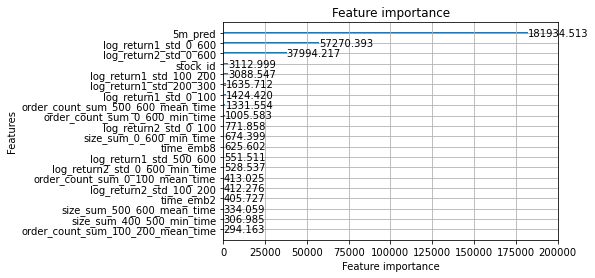

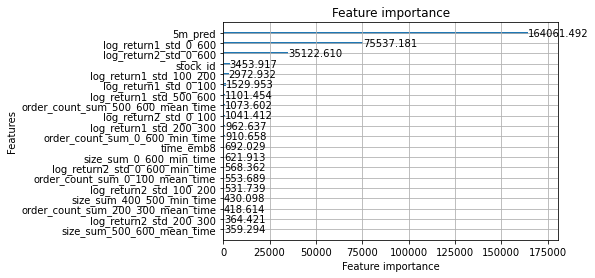

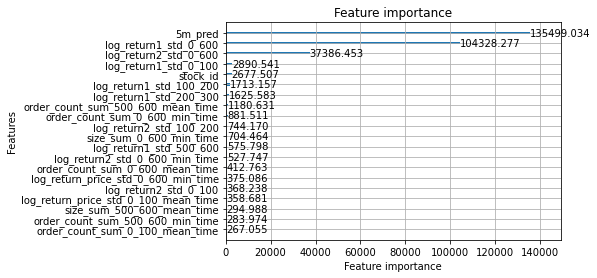

In [28]:
for m in models[:3]:
    lgb.plot_importance(m, max_num_features=20, importance_type='gain')

## Train NN

In [65]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [71]:


def train_nn(train_df, test_df, split):
    cont_nn,cat_nn = cont_cat_split(train_df, max_card=9000, dep_var='target')
    cat_nn = []

    train_df, test_df = train_df.fillna(0), test_df.fillna(0)
    procs_nn = [Categorify,Normalize]
    dls = TabularPandas(train_df, procs_nn, cat_nn, cont_nn,
                          splits=split, y_names='target').dataloaders(1024)

 

    config={'lin_first':False, 'embed_p':.1, 'ps':[0,.4,0]}
    learn = tabular_learner(dls, y_range=(0,.1), layers=[400,200,100], 
                            n_out=1, 
                            loss_func = rmspe, opt_func=ranger,
                            metrics=AccumMetric(rmspe), config=config)

    learn.fit_flat_cos(20, 5e-3, wd=.2)
    
    test_dl = dls.test_dl(test_df)
    preds, _ = learn.get_preds(dl=test_dl)
    score =rmspe_np(test_10m_with_embs.target, preds.view(-1).numpy())
    print(score)
    return preds

### With drop

In [72]:
to_drop = [c for c in train_10m_with_embs.columns.to_list() if c.endswith('_time') or c.endswith('_stock')] + ['stock_id']

In [73]:
train_10m_drop = train_10m_with_embs.drop(to_drop, axis=1)

In [74]:
test_10m_drop = test_10m_with_embs.drop(to_drop, axis=1)

In [75]:
splits = GroupKFold().split(train_10m_with_embs, groups = train_10m_with_embs.time_id)

preds=[]
for trn_idx, val_idx in splits:
    p = train_nn(train_10m_drop, test_10m_drop, [list(trn_idx), list(val_idx)])
    preds.append(p)

epoch,train_loss,valid_loss,rmspe,time
0,0.333968,0.245488,0.248522,00:01
1,0.259397,0.231847,0.233271,00:01
2,0.255105,0.225981,0.227400,00:01
3,0.247208,0.231671,0.233419,00:01
4,0.246659,0.224702,0.226466,00:01
5,0.243846,0.224303,0.225830,00:01
6,0.243376,0.225147,0.226461,00:01
7,0.243450,0.226038,0.227745,00:01
8,0.239371,0.222318,0.223725,00:01
9,0.237304,0.222550,0.223982,00:01


0.22473661805384754


epoch,train_loss,valid_loss,rmspe,time
0,0.315994,0.241154,0.243552,00:01
1,0.263977,0.246235,0.250800,00:01
2,0.256450,0.228358,0.230175,00:01
3,0.259934,0.231774,0.234112,00:01
4,0.242280,0.224074,0.226143,00:01
5,0.246739,0.233944,0.235645,00:01
6,0.240491,0.222343,0.224294,00:01
7,0.241496,0.222055,0.223857,00:01
8,0.239650,0.227082,0.229425,00:01
9,0.237528,0.228487,0.230599,00:01


0.22426739546208316


epoch,train_loss,valid_loss,rmspe,time
0,0.332522,0.250007,0.252545,00:01
1,0.258496,0.233542,0.235078,00:01
2,0.252614,0.232823,0.234657,00:01
3,0.244021,0.232027,0.233543,00:01
4,0.242760,0.229888,0.231349,00:01
5,0.244775,0.235466,0.237144,00:01
6,0.241864,0.232992,0.234513,00:01
7,0.241024,0.233079,0.234564,00:01
8,0.242886,0.229520,0.231147,00:01
9,0.237608,0.229823,0.231454,00:01


0.2257053631025295


epoch,train_loss,valid_loss,rmspe,time
0,0.333649,0.246144,0.248747,00:01
1,0.257774,0.266918,0.267888,00:01
2,0.249060,0.235649,0.237204,00:01
3,0.247134,0.236654,0.238340,00:01
4,0.245785,0.241098,0.243028,00:01
5,0.242695,0.228606,0.229989,00:01
6,0.242058,0.237524,0.238768,00:01
7,0.243118,0.228141,0.229439,00:01
8,0.237778,0.230995,0.232326,00:01
9,0.238026,0.229732,0.231170,00:01


0.2252855698033757


epoch,train_loss,valid_loss,rmspe,time
0,0.313471,0.232254,0.233837,00:01
1,0.264205,0.245989,0.247612,00:01
2,0.253779,0.227254,0.228739,00:01
3,0.250536,0.230606,0.231915,00:01
4,0.247231,0.233943,0.235368,00:01
5,0.245296,0.227647,0.228875,00:01
6,0.245694,0.227039,0.228205,00:01
7,0.241972,0.224236,0.225602,00:01
8,0.240151,0.226069,0.227484,00:01
9,0.237359,0.230411,0.231648,00:01


0.22353258864625525


In [76]:
preds_drop = preds
score = rmspe_np(test_10m_with_embs.target,torch.cat(preds_drop, dim=1).mean(dim=1).numpy())

score

0.22363726823483732

### without drop

In [52]:
splits = GroupKFold().split(train_10m_with_embs, groups = train_10m_with_embs.time_id)

preds=[]
for trn_idx, val_idx in splits:
    p = train_nn(train_10m_with_embs, test_10m_with_embs, [list(trn_idx), list(val_idx)])
    preds.append(p)

epoch,train_loss,valid_loss,rmspe,time
0,0.298982,0.227080,0.228568,00:03
1,0.255052,0.226894,0.227984,00:04
2,0.251376,0.221088,0.222442,00:03
3,0.246238,0.220242,0.221642,00:03
4,0.241290,0.214235,0.215608,00:03
5,0.238747,0.214301,0.215668,00:03
6,0.235366,0.215670,0.217108,00:03
7,0.234796,0.216841,0.218128,00:03
8,0.233043,0.213893,0.215436,00:03
9,0.231848,0.213557,0.215061,00:03


0.22590337293980173


epoch,train_loss,valid_loss,rmspe,time
0,0.332059,0.240387,0.242075,00:03
1,0.262179,0.222239,0.225661,00:03
2,0.255269,0.223327,0.224766,00:03
3,0.246779,0.219776,0.221809,00:03
4,0.243803,0.216435,0.217973,00:03
5,0.240136,0.218447,0.221790,00:03
6,0.240434,0.213428,0.214885,00:03
7,0.234196,0.213939,0.215517,00:03
8,0.234813,0.213803,0.215335,00:03
9,0.232715,0.212653,0.214136,00:03


0.22253315845838903


epoch,train_loss,valid_loss,rmspe,time
0,0.344220,0.237931,0.242435,00:04
1,0.258168,0.224719,0.227442,00:04
2,0.249161,0.222764,0.225141,00:04
3,0.249302,0.230233,0.232093,00:04
4,0.244991,0.223811,0.225678,00:04
5,0.240060,0.218770,0.221091,00:04
6,0.236301,0.217696,0.219994,00:04
7,0.234546,0.214291,0.216164,00:04
8,0.234824,0.216086,0.217818,00:04
9,0.233726,0.215812,0.217891,00:04


0.22573750966564196


epoch,train_loss,valid_loss,rmspe,time
0,0.325402,0.233345,0.234662,00:03
1,0.264312,0.236811,0.238484,00:04
2,0.248153,0.228692,0.230158,00:04
3,0.245053,0.226543,0.228000,00:04
4,0.241434,0.229160,0.230282,00:04
5,0.237003,0.222225,0.223480,00:04
6,0.235562,0.221145,0.222448,00:04
7,0.232000,0.222796,0.224076,00:03
8,0.232319,0.223399,0.224709,00:04
9,0.232284,0.222037,0.223313,00:04


0.22073103140219755


epoch,train_loss,valid_loss,rmspe,time
0,0.307144,0.237224,0.238358,00:04
1,0.264338,0.230893,0.233462,00:04
2,0.252058,0.227178,0.228493,00:04
3,0.247116,0.219854,0.221162,00:04
4,0.240705,0.222596,0.224064,00:04
5,0.240795,0.222661,0.224251,00:04
6,0.235375,0.218733,0.219908,00:04
7,0.234975,0.219815,0.220912,00:04
8,0.235315,0.221304,0.222402,00:04
9,0.231441,0.217308,0.218615,00:04


0.22678488377287329


In [54]:
preds_embs = preds
score = rmspe_np(test_10m_with_embs.target,torch.cat(preds_embs, dim=1).mean(dim=1).numpy())

score

0.21848193980200234

## Baseline without embs

In [34]:
splits = GroupKFold().split(train_10m_without_embs, groups = train_10m_without_embs.time_id)

preds=[]
for trn_idx, val_idx in splits:
    p = train_nn(train_10m_without_embs, test_10m_without_embs, [list(trn_idx), list(val_idx)])
    preds.append(p)

epoch,train_loss,valid_loss,rmspe,time
0,0.315471,0.231719,0.233181,00:03
1,0.257831,0.225645,0.226906,00:03
2,0.251348,0.222792,0.224441,00:03
3,0.249646,0.223894,0.225721,00:03
4,0.245495,0.215345,0.216848,00:03
5,0.240822,0.214591,0.215859,00:03
6,0.237818,0.217344,0.218620,00:03
7,0.236085,0.218724,0.220118,00:03
8,0.232433,0.213775,0.215145,00:03
9,0.229866,0.216375,0.217785,00:03


0.225849491673877


epoch,train_loss,valid_loss,rmspe,time
0,0.327383,0.227852,0.229106,00:04
1,0.254122,0.225149,0.226811,00:04
2,0.254435,0.219808,0.222111,00:04
3,0.246160,0.215652,0.217579,00:03
4,0.242686,0.215946,0.217501,00:04
5,0.239192,0.218993,0.220424,00:04
6,0.236121,0.215663,0.217695,00:04
7,0.235946,0.218818,0.220294,00:04
8,0.235093,0.226731,0.227995,00:03
9,0.232655,0.212326,0.214166,00:03


0.2191881311790737


epoch,train_loss,valid_loss,rmspe,time
0,0.312765,0.239436,0.241051,00:03
1,0.254282,0.227293,0.229437,00:03
2,0.250745,0.226908,0.228805,00:03
3,0.244369,0.224285,0.226794,00:03
4,0.238726,0.218855,0.220886,00:03
5,0.238820,0.220185,0.222533,00:03
6,0.235720,0.216852,0.218851,00:03
7,0.232786,0.218328,0.220247,00:03
8,0.232298,0.219674,0.221695,00:03
9,0.230084,0.224453,0.226503,00:03


0.22900986280272992


epoch,train_loss,valid_loss,rmspe,time
0,0.342332,0.239310,0.240894,00:04
1,0.264999,0.232725,0.233983,00:04
2,0.254123,0.236492,0.237607,00:04
3,0.247179,0.230202,0.231403,00:04
4,0.241907,0.223189,0.224723,00:04
5,0.242087,0.223793,0.225953,00:04
6,0.238540,0.226258,0.227898,00:04
7,0.232766,0.222170,0.223332,00:04
8,0.231291,0.222157,0.223401,00:04
9,0.231688,0.220496,0.221804,00:04


0.2248933965342927


epoch,train_loss,valid_loss,rmspe,time
0,0.352057,0.235927,0.237847,00:04
1,0.262650,0.225490,0.226656,00:04
2,0.254931,0.222142,0.223451,00:04
3,0.248850,0.220856,0.222350,00:04
4,0.247495,0.220586,0.222005,00:04
5,0.240147,0.225753,0.226798,00:04
6,0.236463,0.220886,0.221980,00:04
7,0.239136,0.220392,0.222229,00:04
8,0.234026,0.217175,0.218378,00:04
9,0.234662,0.220810,0.222089,00:04


0.22245921220738846


In [37]:
preds_without=preds

score = rmspe_np(test_10m_without_embs.target,torch.cat(preds_without, dim=1).mean(dim=1).numpy())

score

0.2192198478286222

In [77]:
#ensmble
score = rmspe_np(test_10m_without_embs.target,torch.cat(preds_without+preds_drop, dim=1).mean(dim=1).numpy())


score

0.21622887774663857

In [55]:
#ensmble
score = rmspe_np(test_10m_without_embs.target,torch.cat(preds_without+preds_embs, dim=1).mean(dim=1).numpy())


score

0.21843388407230546

In [56]:
#ensmble
score = rmspe_np(test_10m_without_embs.target,torch.cat(preds_without+preds_embs+preds_drop, dim=1).mean(dim=1).numpy())


score

0.2159442246904259